# Maize Plant Disease Detection Starter Notebook

# AI for Crop Health - Diagnosing Maize Plant Diseases in Zimbabwe Using Deep Learning

## 📌 Info Page

### About the Challenge
Maize is the staple crop that sustains millions of Zimbabweans, underpinning both food security and livelihoods across rural and urban communities. Yet, Zimbabwe’s maize production is persistently threatened by several devastating leaf diseases—primarily **Common Rust**, **Gray Leaf Spot**, and **Blight**—which cause significant yield reductions and economic losses.

These diseases are widespread across Zimbabwe’s diverse agro-ecological zones, including:
- High-rainfall areas like **Mashonaland East** and **Manicaland**.
- Drier regions like **Masvingo**.
- The central **Midlands**.

Their impact is exacerbated by limited access to timely and accurate disease diagnostics, especially for smallholder farmers who form the backbone of Zimbabwe’s agriculture.

### Your Task
Develop **deep learning models** that can accurately detect and classify maize diseases from leaf images. Leveraging AI for early and precise disease identification can transform farming practices by:
- Providing farmers with **real-time, accessible tools** to identify diseases before they spread widely.
- Reducing reliance on **manual inspection**, which is often subjective and slow.
- Enabling **targeted interventions** to minimize crop loss and reduce pesticide overuse.
- Contributing to **improved food security** and agricultural sustainability in Zimbabwe.

### Dataset Overview
The dataset includes images of maize leaves categorized into:
1. **Common Rust**
2. **Gray Leaf Spot**
3. **Blight**
4. **Healthy**

Your challenge is to design and train models robust to diverse field conditions (e.g., varying lighting, leaf angles, and disease severity).

### Impact
By addressing this challenge, you will contribute to a **high-impact solution** with direct applications in Zimbabwe’s farming communities and beyond, driving the adoption of AI-powered precision agriculture in sub-Saharan Africa.

---

## 📊 Evaluation
- **Metrics**: Accuracy, Precision, Recall, F1-Score.
- **Leaderboard**: Based on performance on the evaluation set.
# 
### 🏆 Prizes
 - **Top 3 performers** will receive:
   - Official certification of achievement
   - Recognition on our community platforms
   - Priority consideration for future opportunities with:
     - The Deep Learning Indaba X Zimbabwe community
     - Agricultural sector partners

## ⏳ Timeline
- **Start Date**: [Insert Date]
- **Submission Deadline**: [Insert Date]
- **Results Announcement**: [Insert Date]

## 📜 Rules
- This challenge is **only open to the Deep Learning Indaba X Zimbabwe Community**.
- Teams must adhere to the **code of conduct** and **submission guidelines**.

---

## 📂 Data Page

### About the Data
The dataset contains labelled images of crop leaves, categorized into four classes:

| Class          | Label | Number of Images |
|----------------|-------|------------------|
| Common Rust    | 0     | 1,306            |
| Gray Leaf Spot | 1     | 574              |
| Blight         | 2     | 1,146            |
| Healthy        | 3     | 1,162            |





# 🌱 Starter Notebook:  Maize Plant Disease Detection 

## 📌 Overview
This notebook serves as a **starter template** for the *AI for Crop Health* hackathon challenge. It provides a foundational workflow for loading, preprocessing, and analyzing the maize disease dataset, as well as training a baseline deep learning model. Use this as a jumping-off point to build and refine your solution.

---

## 🎯 Objectives
By the end of this notebook, you will:
1. **Explore the dataset**: Visualize sample images and understand class distributions.
2. **Preprocess data**: Resize, normalize, and augment images for model training.
3. **Train a baseline model**: Implement a simple CNN or transfer learning model.
4. **Evaluate performance**: Calculate metrics (accuracy, F1-score) and identify areas for improvement.

---

## **Importing Libraries**

In [85]:
import os

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm import tqdm

In [86]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"


### Exploring and Preparing Our Data

In [87]:
train_data_dir = os.path.join("crop pictures", "train")
test_data_dir = os.path.join("crop pictures", "test")
print("Data Directory:", train_data_dir)
print("Data Directory:", test_data_dir)

Data Directory: crop pictures\train
Data Directory: crop pictures\test


In [88]:
#Create and print a list of class names in our directory
classes = os.listdir(train_data_dir)

print("List of classes:", classes)


List of classes: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [89]:
# Convert grayscale images to RGB format since our model expects 3-channel input
# Grayscale images only have 1 channel, which would cause dimension mismatch errors
# This ensures all images have consistent 3-channel RGB format for model training
def convert_to_rgb(img):
    """Convert PIL image to RGB format if it isn't already.
    
    Args:
        img: PIL Image object
    
    Returns:
        PIL Image object in RGB format
    """
    if img.mode != "RGB":
        img = img.convert("RGB")
    return img

In [90]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [91]:
# Resize images to 224x224 to ensure consistent input dimensions for the model (common size for CNNs)
# Convert images to tensors to enable GPU acceleration and matrix operations
# Normalize each color channel separately (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
# to standardize pixel values across the dataset (values based on ImageNet statistics)
# First create a basic transform to get images to tensor format for mean/std calculation


# Final transform with calculated normalization values
transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),  # First convert to RGB if needed
    transforms.Resize((224, 224)),      # Resize to 224x224
    transforms.ToTensor(),              # Convert to tensor
])


print(type(transform))
print("-----------------")
print(transform)

<class 'torchvision.transforms.transforms.Compose'>
-----------------
Compose(
    Lambda()
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [92]:
#We make a normalizes dataset using ImageFolder from datasets and print lenght
training_dataset = datasets.ImageFolder(train_data_dir,transform)
test_dataset = datasets.ImageFolder(test_data_dir,transform)
print('Length of training dataset:', len(training_dataset))
print('Length of test dataset:', len(test_dataset))

Length of training dataset: 2930
Length of test dataset: 632


Computing class counts for training data...


Training data counts:
Blight            802
Common_Rust       914
Gray_Leaf_Spot    401
Healthy           813
dtype: int64

Computing class counts for test data...
Test data counts:
Blight            173
Common_Rust       197
Gray_Leaf_Spot     87
Healthy           175
dtype: int64


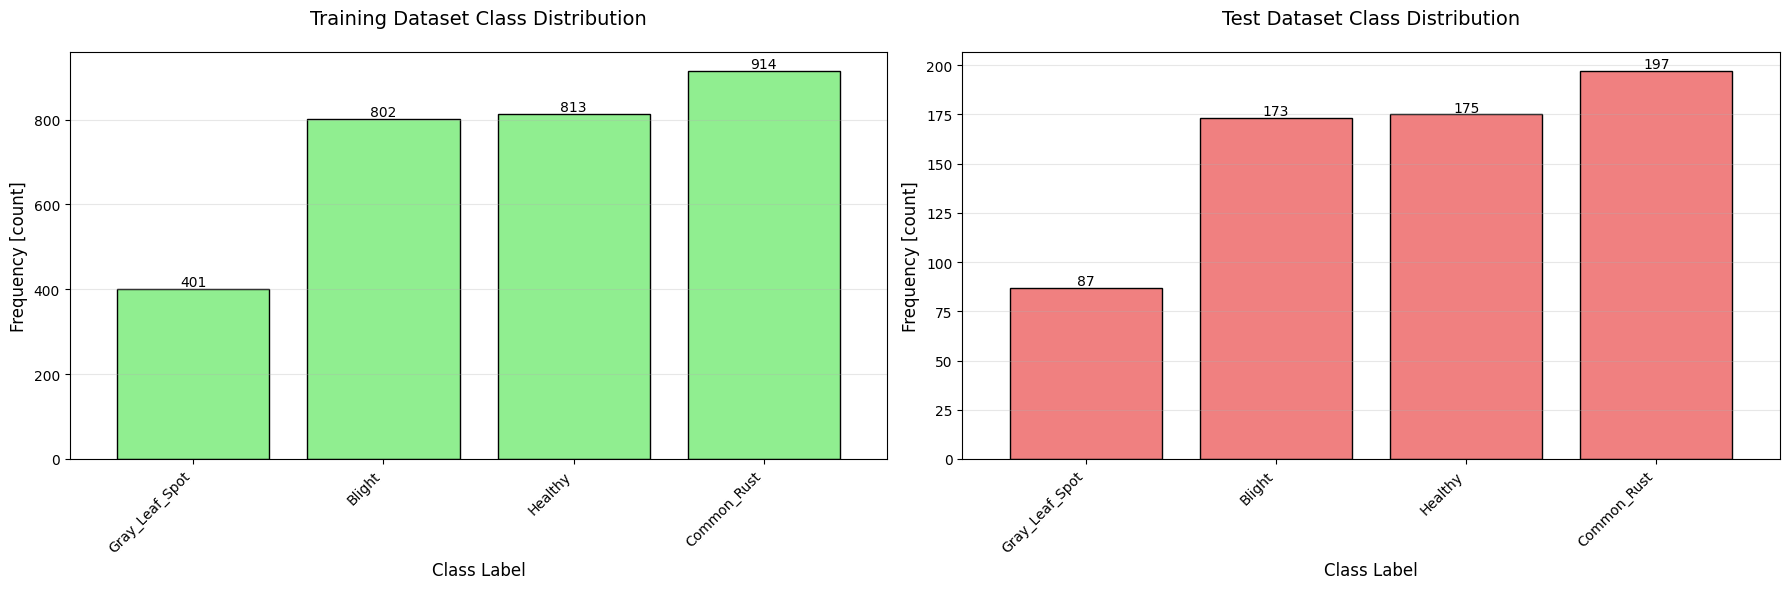

In [93]:
# Define function to count class instances
def class_counts(dataset):
    counts = {}
    for _, label in dataset:
        class_name = dataset.classes[label]
        counts[class_name] = counts.get(class_name, 0) + 1
    return pd.Series(counts)

# Calculate class counts for both training and test datasets
print("Computing class counts for training data...")
train_counts = class_counts(training_dataset)
print("Training data counts:")
print(train_counts)
print("\nComputing class counts for test data...")
test_counts = class_counts(test_dataset)
print("Test data counts:")
print(test_counts)

# Create figure with subplots
plt.figure(figsize=(18, 6))

# Plot training data distribution
plt.subplot(1, 2, 1)
ax1 = train_counts.sort_values().plot(
    kind='bar',
    color='lightgreen',
    edgecolor='black',
    width=0.8
)
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Frequency [count]", fontsize=12)
plt.title("Training Dataset Class Distribution", fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Plot test data distribution
plt.subplot(1, 2, 2)
ax2 = test_counts.sort_values().plot(
    kind='bar',
    color='lightcoral',
    edgecolor='black',
    width=0.8
)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Frequency [count]", fontsize=12)
plt.title("Test Dataset Class Distribution", fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [94]:
batch_size = 32

train_loader = DataLoader(training_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print(type(train_loader))
print(type(test_loader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [95]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

image_shape = images.shape
print("Shape of batch of images", image_shape)

label_shape =  labels.shape
print("Shape of batch of labels:", label_shape)

Shape of batch of images torch.Size([32, 3, 224, 224])
Shape of batch of labels: torch.Size([32])


## Model Building -Convolutional Neural Network

In [96]:
model = torch.nn.Sequential(
    # Minimal convolutional block
    nn.Conv2d(3, 8, kernel_size=3, padding=1),  # Reduced channels
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    # Single fully-connected layer
    nn.Flatten(),
    nn.Linear(8 * 112 * 112, 4)  # Direct to output with reduced dimensions
)
print(model)


Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=100352, out_features=4, bias=True)
)


## Training Our Model

In [97]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

print(loss_fn)
print("----------------------")
print(optimizer)

CrossEntropyLoss()
----------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [98]:
height = 224
width = 224
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Conv2d: 1-1                            [32, 8, 224, 224]         224
├─ReLU: 1-2                              [32, 8, 224, 224]         --
├─MaxPool2d: 1-3                         [32, 8, 112, 112]         --
├─Flatten: 1-4                           [32, 100352]              --
├─Linear: 1-5                            [32, 4]                   401,412
Total params: 401,636
Trainable params: 401,636
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 372.51
Input size (MB): 19.27
Forward/backward pass size (MB): 102.76
Params size (MB): 1.61
Estimated Total Size (MB): 123.64

In [100]:
def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=5,
    device='cpu',
    use_train_accuracy=True,
):
    model.to(device)
    
    # Initialize lists to store metrics
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            if use_train_accuracy:
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        # Calculate and store metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        test_losses.append(val_loss)
        
        if use_train_accuracy:
            train_acc = 100 * correct_train / total_train
            train_accuracies.append(train_acc)
        test_acc = 100 * correct_val / total_val
        test_accuracies.append(test_acc)
        
        # Print statistics
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss:.4f}', end=' ')
        if use_train_accuracy:
            print(f'- Train Acc: {train_acc:.2f}%', end=' ')
        print(f'- Val Loss: {val_loss:.4f} - Val Acc: {test_acc:.2f}%')
    
    return train_losses, test_losses, train_accuracies, test_accuracies

train_losses, test_losses, train_accuracies, test_accuracies = train(model,optimizer,loss_fn,train_loader,test_loader,epochs=5)


Epoch 1/5
Train Loss: 0.8377 - Train Acc: 56.45% - Val Loss: 0.8205 - Val Acc: 56.33%
Epoch 2/5
Train Loss: 0.8306 - Train Acc: 55.67% - Val Loss: 0.8370 - Val Acc: 57.91%
Epoch 3/5
Train Loss: 0.8250 - Train Acc: 57.37% - Val Loss: 0.8615 - Val Acc: 57.75%
Epoch 4/5
Train Loss: 0.8336 - Train Acc: 57.95% - Val Loss: 0.8344 - Val Acc: 57.12%
Epoch 5/5
Train Loss: 0.8197 - Train Acc: 58.33% - Val Loss: 0.8434 - Val Acc: 56.96%


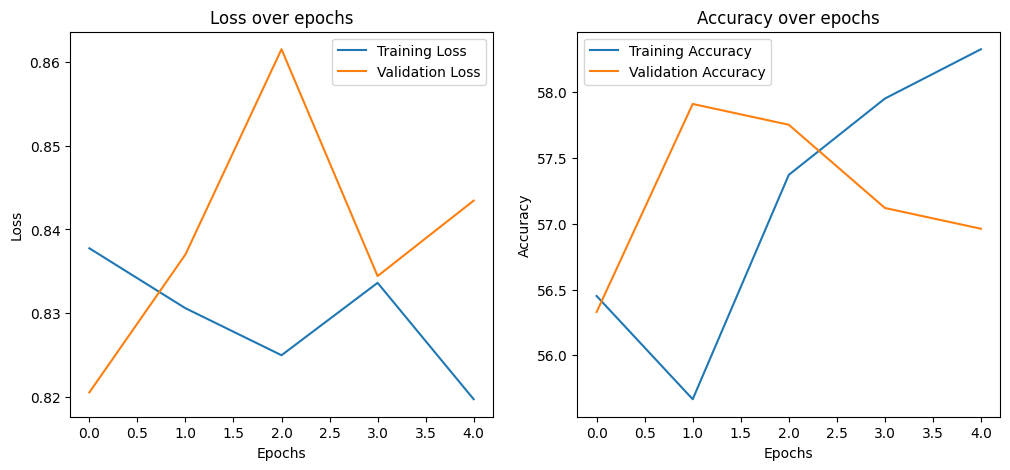

In [101]:
## Model Evalutions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(test_accuracies, label="Validation Accuracy")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### Overall Assessment
**Overfitting**: The divergence between training and validation metrics suggests potential overfitting. The model performs well on training data but struggles to generalize to validation data.

### Next Steps:
1. **Regularization**: Consider adding techniques like dropout or L2 regularization to mitigate overfitting.
2. **Data Augmentation**: Implement data augmentation strategies to increase the diversity of the training dataset.
3. **Early Stopping**: Use early stopping based on validation loss to prevent overfitting.
4. **Hyperparameter Tuning**: Experiment with different learning rates, batch sizes, or model architectures.


In [102]:
def predict(model, data_loader):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for images, _ in data_loader:
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs)
    return torch.cat(all_probs, dim=0)

probabilities_val = predict(model, test_loader)
predictions_val = torch.argmax(probabilities_val, dim=1)

print(predictions_val)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 1, 3, 0, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [103]:
targets_val = torch.cat(
    [labels for _, labels in tqdm(test_loader, desc="Get Labels")]
)

Get Labels: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


<Figure size 1000x800 with 0 Axes>

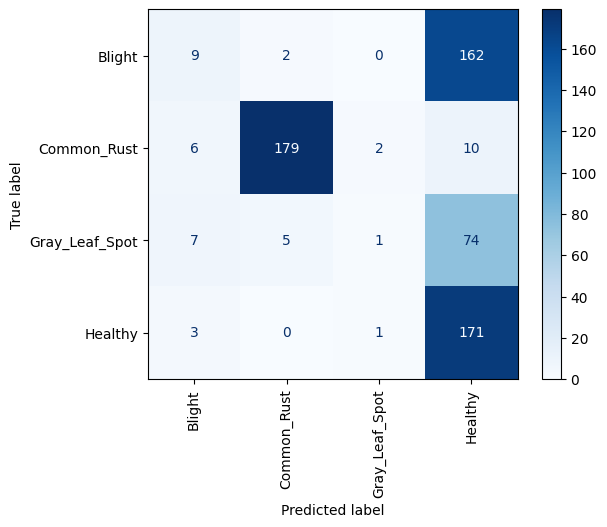

In [104]:
cm = confusion_matrix(targets_val.cpu(), predictions_val.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Set figure size
plt.figure(figsize=(10, 8))

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show()

## Submission to Hackathon

In [105]:
val_dir = os.path.join('crop pictures','val')

print(val_dir)

crop pictures\val


In [106]:
def file_to_confidence(model, datadir, filename, transform_pipeline):
    file_path = os.path.join(datadir, filename)
    image = PIL.Image.open(file_path)
    transformed = transform_pipeline(image)
    unsqueezed = transformed.unsqueeze(0)
    image_cuda = unsqueezed.to(device)

    model.eval()
    with torch.no_grad():
        model_raw = model(image_cuda)
        confidence = torch.nn.functional.softmax(model_raw, dim=1)

    conf_df = pd.DataFrame([[filename] + confidence.tolist()[0]])
    conf_df.columns = ["ID"] + training_dataset.classes

    return conf_df

In [107]:
training_dataset.classes

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [110]:
blight_train_dir = os.path.join('crop pictures','train','blight')
blight_images = os.listdir(blight_train_dir)

file_to_confidence(model, blight_train_dir, blight_images[7], transform)

,ID,Blight,Common_Rust,Gray_Leaf_Spot,Healthy
0,Corn_Blight (1007).JPG,0.38357,0.03262,0.17988,0.40393


In [111]:
# Convert scientific notation to standard decimals
pd.set_option('display.float_format', lambda x: '%.5f' % x)

small_dfs = []

for filename in tqdm(os.listdir(val_dir), desc="Predicting on test set"):
    small_dfs.append(
        file_to_confidence(model, val_dir, filename, transform)
    )

confidence_df = pd.concat(small_dfs)

confidence_df = confidence_df.sort_values("ID").reset_index(drop=True)
confidence_df.head()

Predicting on test set:   0%|          | 0/626 [00:00<?, ?it/s]

Predicting on test set: 100%|██████████| 626/626 [00:03<00:00, 201.07it/s]


,ID,Blight,Common_Rust,Gray_Leaf_Spot,Healthy
0,image_000001.jpg,0.38005,0.03342,0.18867,0.39786
1,image_000002.JPG,0.38357,0.03262,0.17988,0.40393
2,image_000003.JPG,0.00000,1.00000,0.00000,0.00000
3,image_000004.JPG,0.37013,0.03265,0.18693,0.41029
4,image_000005.JPG,0.38357,0.03262,0.17988,0.40393


In [112]:
# 1. Load ground truth and predictions
ground_truth = pd.read_csv('ground_truth.csv')  # Columns: ID, True_Label
    # Your confidence scores output

# 2. Merge them on filename
combined = pd.merge(confidence_df, ground_truth, on='ID')

# 3. Calculate accuracy metrics
from sklearn.metrics import classification_report, accuracy_score

# Get predicted labels (class with highest confidence)
combined['Predicted'] = combined[['Blight','Common_Rust','Gray_Leaf_Spot','Healthy']].idxmax(axis=1)

# Calculate overall accuracy
accuracy = accuracy_score(combined['True_Label'], combined['Predicted'])
print(f"Overall Accuracy: {accuracy:.2%}")

# Detailed class-wise metrics
print("\nClassification Report:")
print(classification_report(
    combined['True_Label'], 
    combined['Predicted'],
    target_names=['Blight','Common_Rust','Gray_Leaf_Spot','Healthy']
))

Overall Accuracy: 54.71%

Classification Report:
                precision    recall  f1-score   support

        Blight       0.25      0.03      0.05       101
   Common_Rust       0.99      0.94      0.96       127
Gray_Leaf_Spot       0.50      0.04      0.08        46
       Healthy       0.30      0.94      0.46        66

      accuracy                           0.55       340
     macro avg       0.51      0.49      0.39       340
  weighted avg       0.57      0.55      0.48       340



In [ ]:
confidence_df.to_csv("submission.csv", index=False)